# Stringency index values as a sequence of symbols
This notebook was created based on: WS1_aw_ProcessMining_StringencyIndexStringCreation

### Objective 
Discover meaningful stringency states common to many countries and explore on how the state transition patterns vary from country to country to group similar countries together.

### Data Source
The Oxford COVID-19 Government Response Tracker (OxCGRT)
- https://github.com/rs-delve/covid19_datasets/

### Clustering technique
This is similar to bag-of-words technique used in the following work, shamelessly referring to my own paper:
- K. Lee et al., "STARE: Spatio-Temporal Attention RElocation for Multiple Structured Activities Detection", <i>IEEE Transactions on Image Processing</i>, 2015.


Author: Kyuhwa Lee

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import string
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.rcParams.update({'figure.max_open_warning': 0})

## Oxford Stringency Index

Data Dictionary: https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md

The Flag denotes, if the measure was applied to a specific region (flag=0) or across the whole country (flag=1), so in order to have a comparability between the countries, we can only take values into account with flag=1!

Most of the values have ordinal values ranging from 0-x. For these values we need to define matching strings.

Also the fileds are left blank when there is no data available. --> should we filter only for countries, for which we do have the same amount of data available?

Also there is put the amount of money which e.g. some countries on vaccine research --> How to put these into a letter?

C - containment and closure policies
E - economic policies
H - health system policies
M - miscellaneous policies

In [3]:
# cleaned version
df = pd.read_csv('https://raw.githubusercontent.com/rs-delve/covid19_datasets/master/dataset/combined_dataset_latest.csv')
df.columns

Index(['ISO', 'DATE', 'country_name', 'npi_school_closing',
       'npi_workplace_closing', 'npi_cancel_public_events',
       'npi_gatherings_restrictions', 'npi_close_public_transport',
       'npi_stay_at_home', 'npi_internal_movement_restrictions',
       'npi_international_travel_controls', 'npi_income_support',
       'npi_debt_relief', 'npi_fiscal_measures', 'npi_international_support',
       'npi_public_information', 'npi_testing_policy', 'npi_contact_tracing',
       'npi_healthcare_investment', 'npi_vaccine_investment',
       'npi_stringency_index', 'npi_masks', 'cases_total', 'cases_new',
       'deaths_total', 'deaths_new', 'cases_total_per_million',
       'cases_new_per_million', 'deaths_total_per_million',
       'deaths_new_per_million', 'tests_total', 'tests_new',
       'tests_total_per_thousand', 'tests_new_per_thousand',
       'tests_new_smoothed', 'tests_new_smoothed_per_thousand',
       'stats_population', 'stats_population_density', 'stats_median_age',
      

### Columns to ignore:
- Miscellanious free text: M1
- Monetary values: E3, E4, H4, H5

In [4]:
# script for data from rs-delve's Github
cols_mapper = {
    'npi_school_closing':'school_closing',
    'npi_workplace_closing':'workplace_closing',
    'npi_cancel_public_events':'cancel_public_events',
    'npi_gatherings_restrictions':'gatherings_restrictions',
    'npi_close_public_transport':'close_public_transport',
    'npi_stay_at_home':'stay_at_home',
    'npi_internal_movement_restrictions':'internal_movement_restrictions',
    'npi_international_travel_controls':'international_travel_controls',
    'npi_income_support':'income_support',
    'npi_debt_relief':'debt_relief',
    #'npi_fiscal_measures':'fiscal_measures',
    #'npi_international_support':'international_support',
    'npi_public_information':'public_information',
    'npi_testing_policy':'testing_policy',
    'npi_contact_tracing':'contact_tracing',
    #'npi_healthcare_investment':'healthcare_investment',
    #'npi_vaccine_investment':'vaccine_investment',
    #'npi_stringency_index':'stringency_index',
    #'npi_masks':'masks',
    'DATE':'Date'
}

var_scales = {'school_closing':3, 'workplace_closing':3, 'cancel_public_events':2,
              'gatherings_restrictions':4, 'close_public_transport':2, 'stay_at_home':3,
              'internal_movement_restrictions':2, 'international_travel_controls':4,
              'income_support':2, 'debt_relief':2,
              'public_information':2, 'testing_policy':3, 'contact_tracing':2}
si_cols = ['country_name', 'Date'] + list(var_scales.keys())

europe = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia',
    'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
    #'Liechtenstein', 
    'Lithuania', 'Luxembourg', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania',
    'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom']

select_countries = None

df_si = df.rename(cols_mapper, axis=1)
#df_si.Date = df_si.Date.apply(str)
if select_countries:
    df_si = df_si[df_si['country_name'].isin(europe)]
si_countries = sorted(df_si['country_name'].unique())
for country in si_countries:
    country_index = (df_si['country_name'] == country)
    df_si.loc[country_index] = df_si.loc[country_index].fillna(method='ffill')
    df_si.loc[country_index] = df_si.loc[country_index].fillna(0)
df_si.head()

,ISO,Date,country_name,school_closing,workplace_closing,cancel_public_events,gatherings_restrictions,close_public_transport,stay_at_home,internal_movement_restrictions,...,stats_population_school_age,deaths_excess_daily_avg,deaths_excess_weekly,weather_precipitation_mean,weather_humidity_mean,weather_sw_radiation_mean,weather_temperature_mean,weather_temperature_min,weather_temperature_max,weather_wind_speed_mean
0,ABW,2020-01-01,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17521.0,0.0,0.0,3.238519e-06,0.016900,220.264984,27.246809,26.732813,27.709375,9.019097
1,ABW,2020-01-02,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17521.0,0.0,0.0,6.755193e-07,0.016645,223.333893,27.049299,26.558985,27.508204,8.752604
2,ABW,2020-01-03,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17521.0,0.0,0.0,1.329184e-05,0.017244,220.742767,27.193014,26.695704,27.582422,8.564670
3,ABW,2020-01-04,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17521.0,0.0,0.0,1.788139e-07,0.016593,225.407074,27.267725,26.775782,27.771875,8.304688
4,ABW,2020-01-05,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17521.0,0.0,0.0,7.867813e-06,0.017142,219.864334,27.255766,26.965235,27.611719,5.604166


# Represent stringency index as bag-of-words representation

In [5]:
#num_symbols_options = [2, 3, 4, 5, 6, 7]
num_symbols_options = [4, 5, 7]
symbol_colors = ['r', 'b' ,'g', 'c', 'm', 'y', 'k']

Bag-of-words using 4 symbols
Bag-of-words using 5 symbols
Bag-of-words using 7 symbols


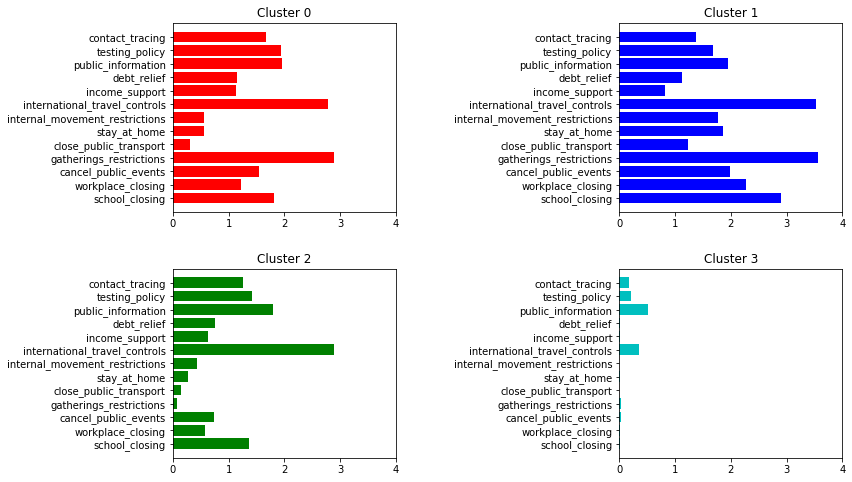

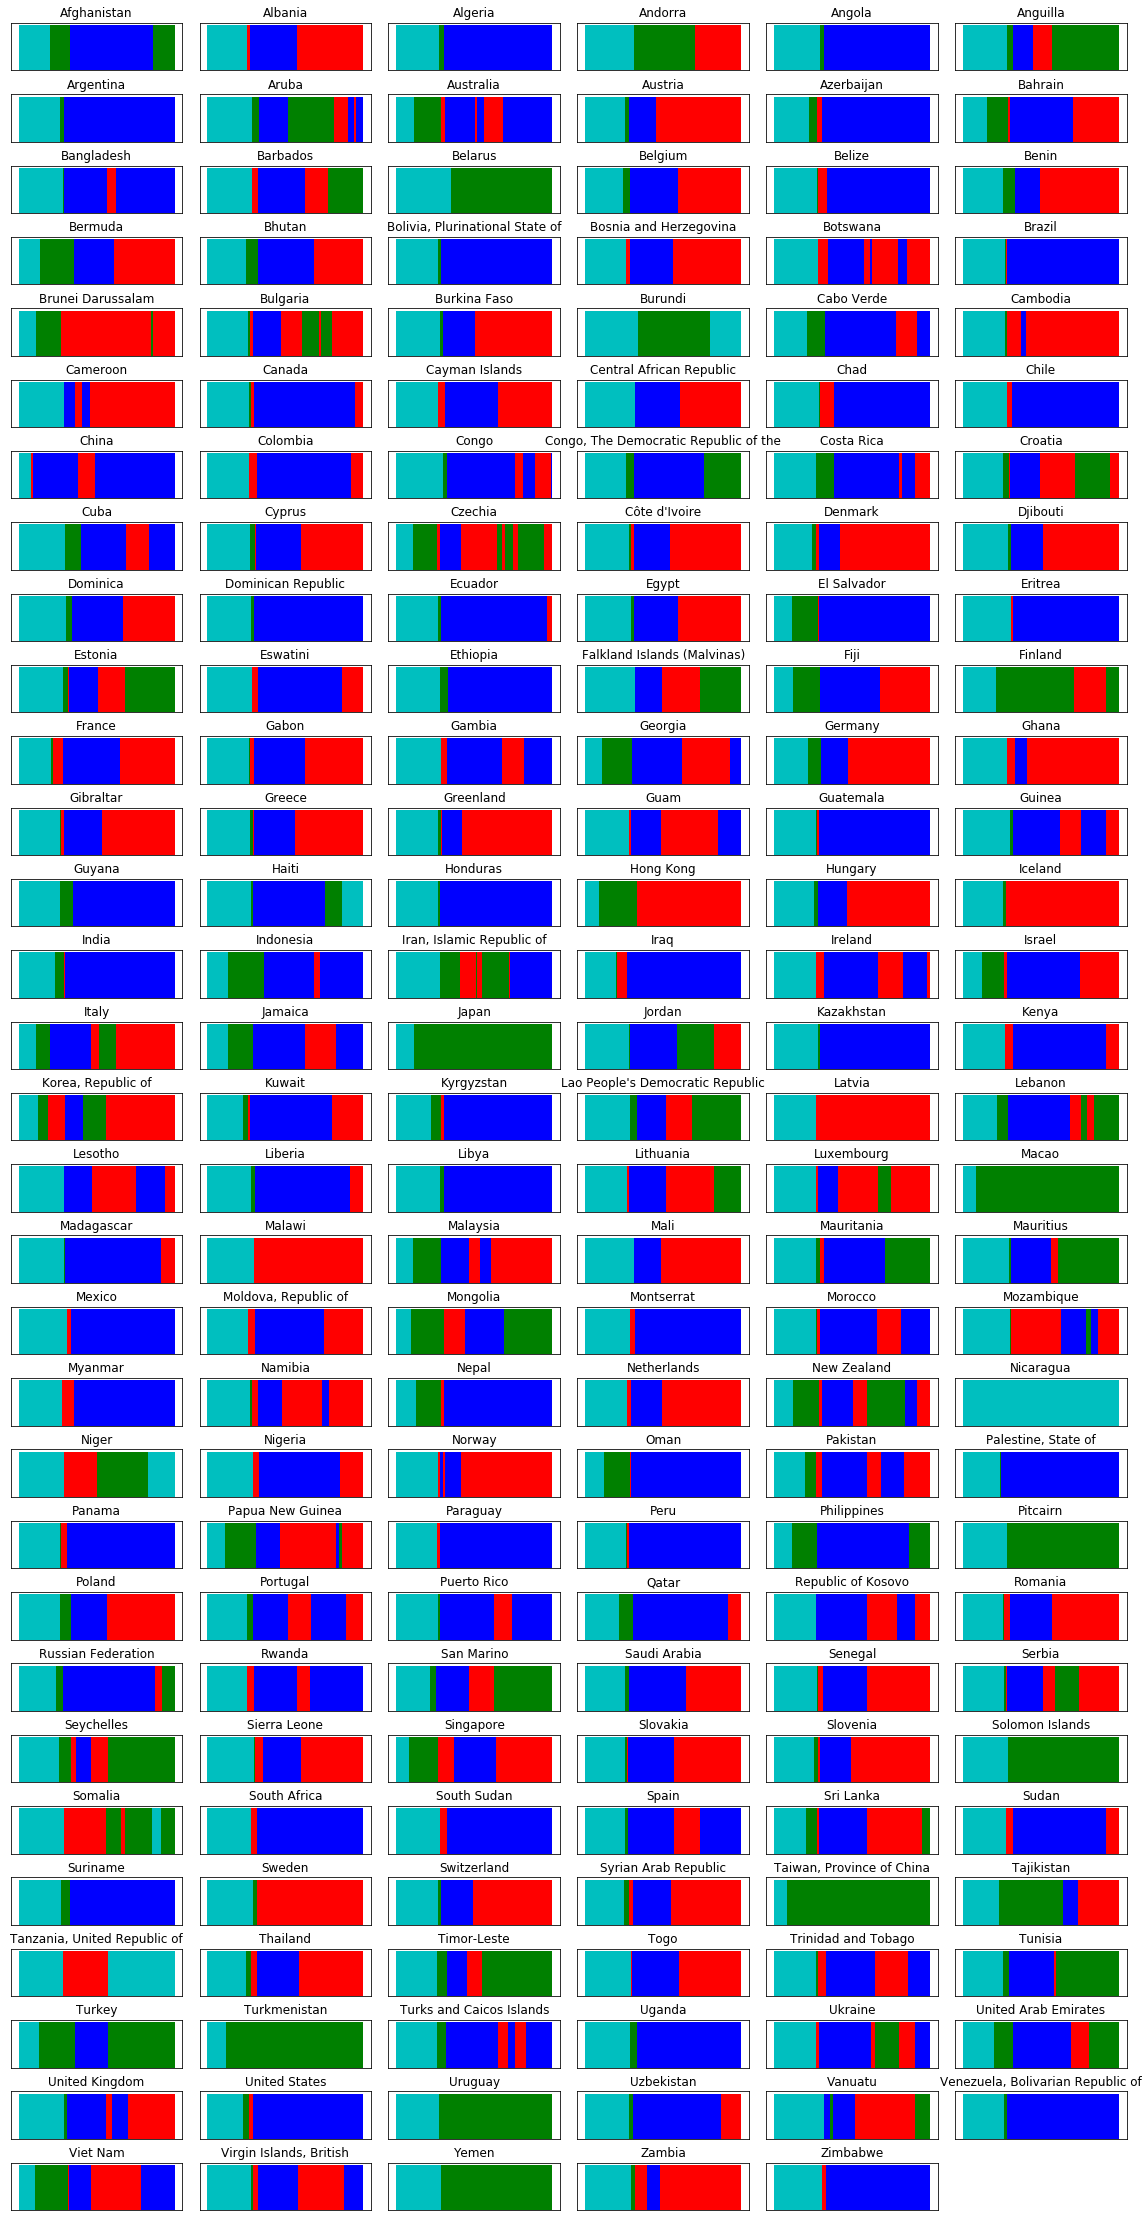

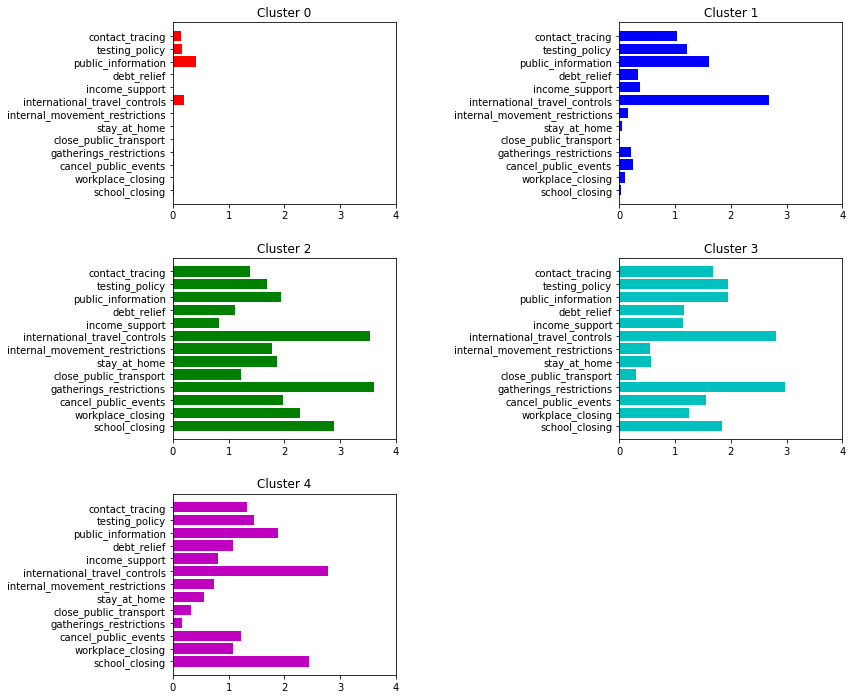

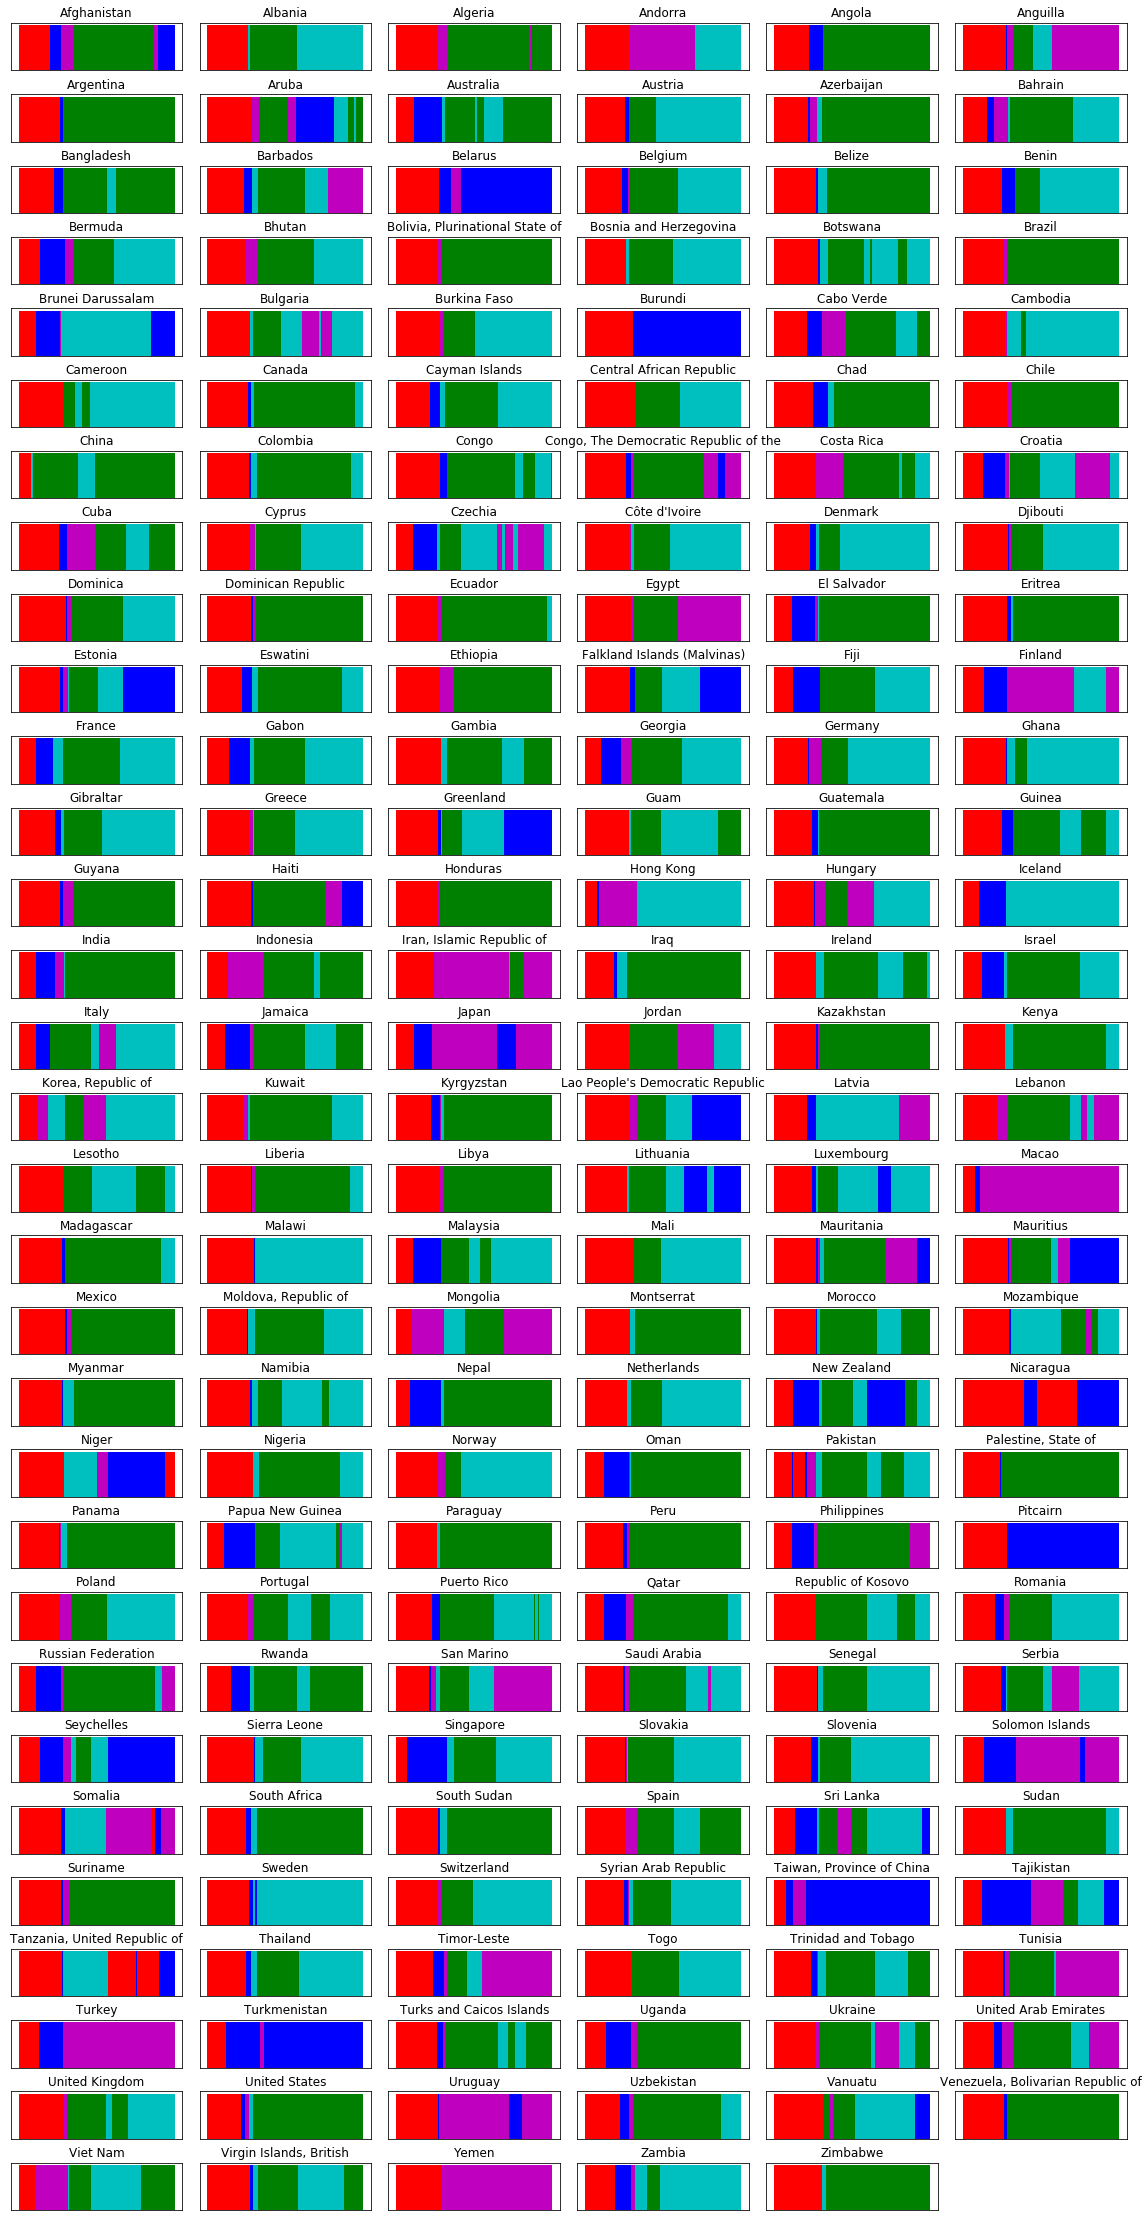

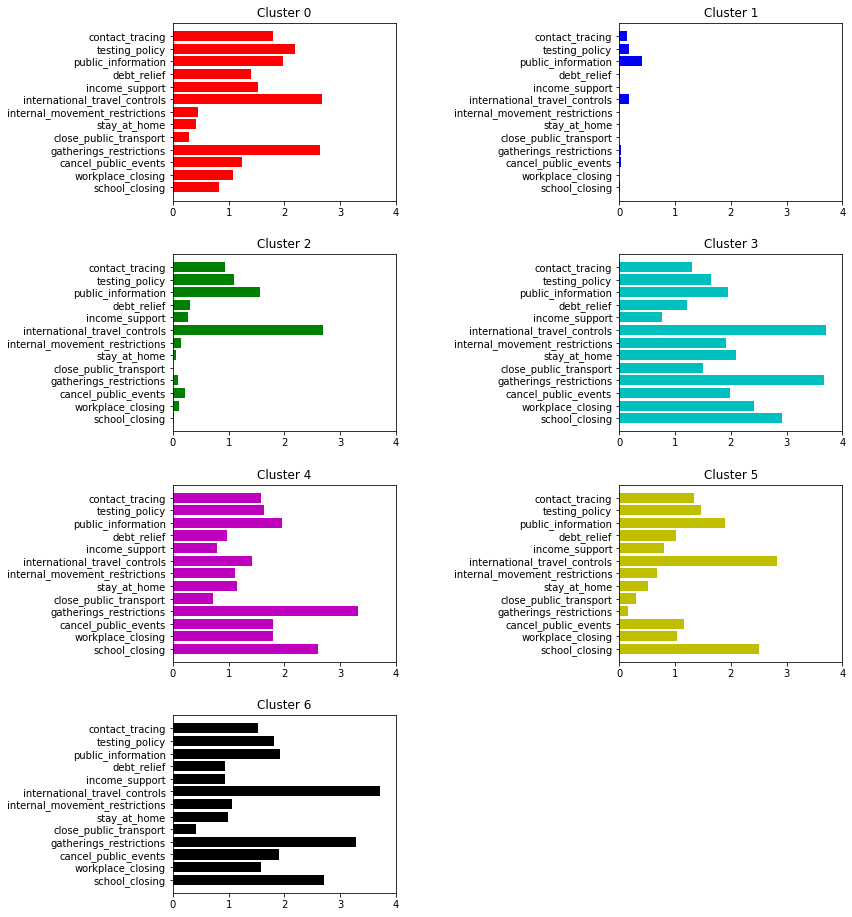

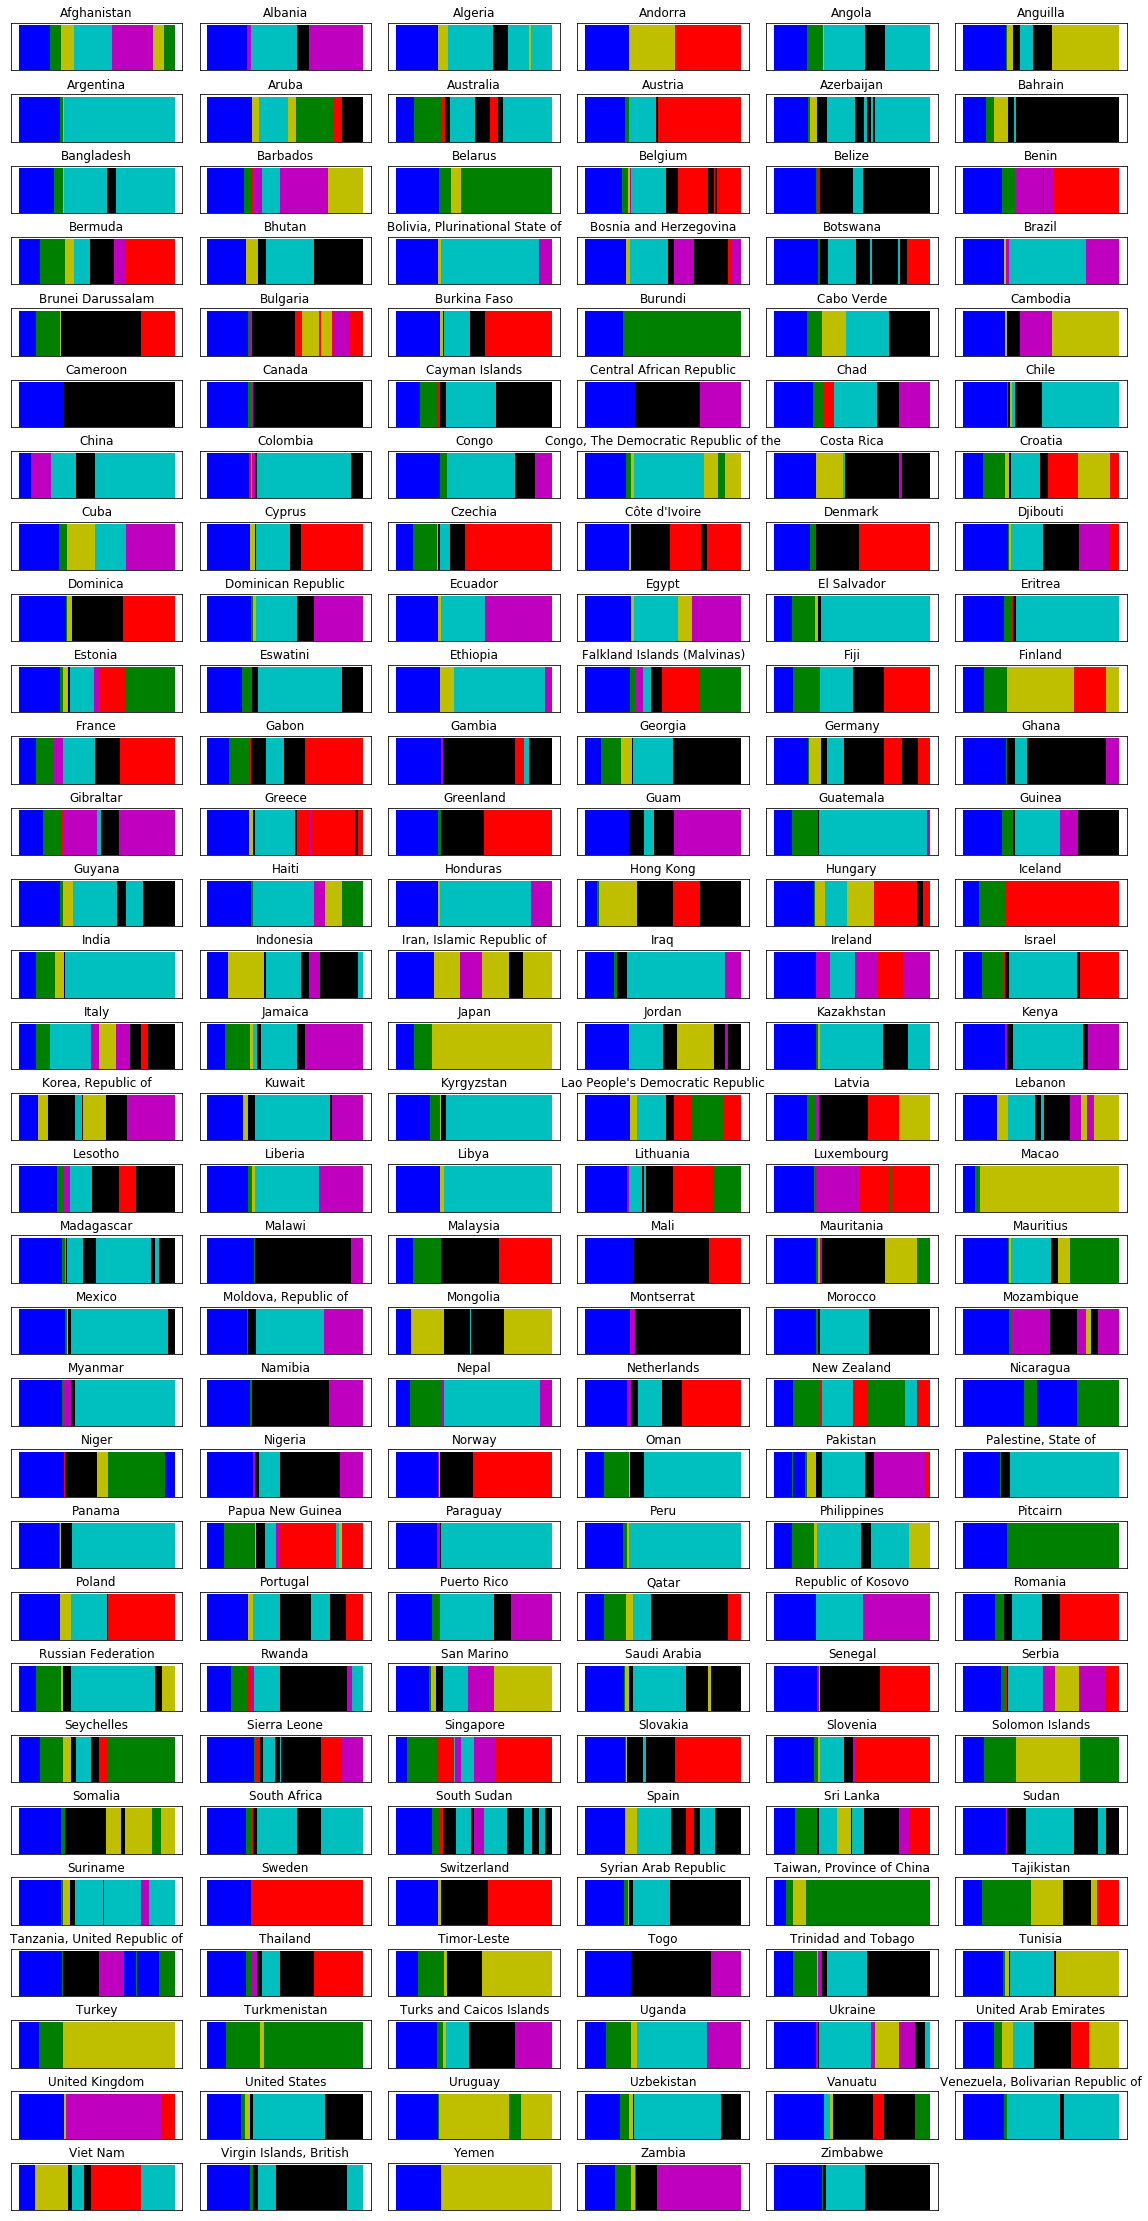

In [5]:
symbolised = {}
df_array = df_si[var_scales].dropna().to_numpy()
for num_symbols in num_symbols_options:
    print('Bag-of-words using %d symbols' % num_symbols)
    # perform clustering
    cols = 2
    km = KMeans(n_clusters=num_symbols, random_state=0).fit(df_array)
    #centers = np.round(km.cluster_centers_)
    centers = km.cluster_centers_
    rows = np.ceil(centers.shape[0] / cols)
    plt.figure(figsize=[12, 4*rows])
    for i in range(centers.shape[0]):
        plt.subplot(rows, 2, i+1)
        plt.barh(y=list(var_scales.keys()), height=0.8, width=centers[i], color=symbol_colors[i])
        #plt.xticks(fontsize=14, ha='right')
        plt.subplots_adjust(wspace=1, hspace=0.3)
        plt.title('Cluster %d' % i)
        plt.xlim([0, 4])

    # visualise bag of words
    cols = 6
    rows = np.ceil(len(si_countries) / cols)
    plt.figure(figsize=[20, 1*rows])
    for i, country in enumerate(si_countries):
        df_country = df_si[df_si['country_name'] == country].set_index('Date', drop=True)[var_scales].dropna()
        if df_country.shape[0] < 10:
            continue
        plt.subplot(rows, cols, i+1)
        labels = km.predict(df_country)
        symbolised[country] = labels
        for s in range(num_symbols):
            plt.bar(x=np.where(labels==s)[0], height=1, color=symbol_colors[s], width=1)
        plt.title(country)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.1)

### Save all data

In [6]:
symbolised['Date'] = df_si[df_si['country_name'] == 'Germany'].Date
df_sym = pd.DataFrame(symbolised).reset_index(drop=True)
df_sym.to_csv('si_clusters_as_strings.csv')

### Data length consistency check

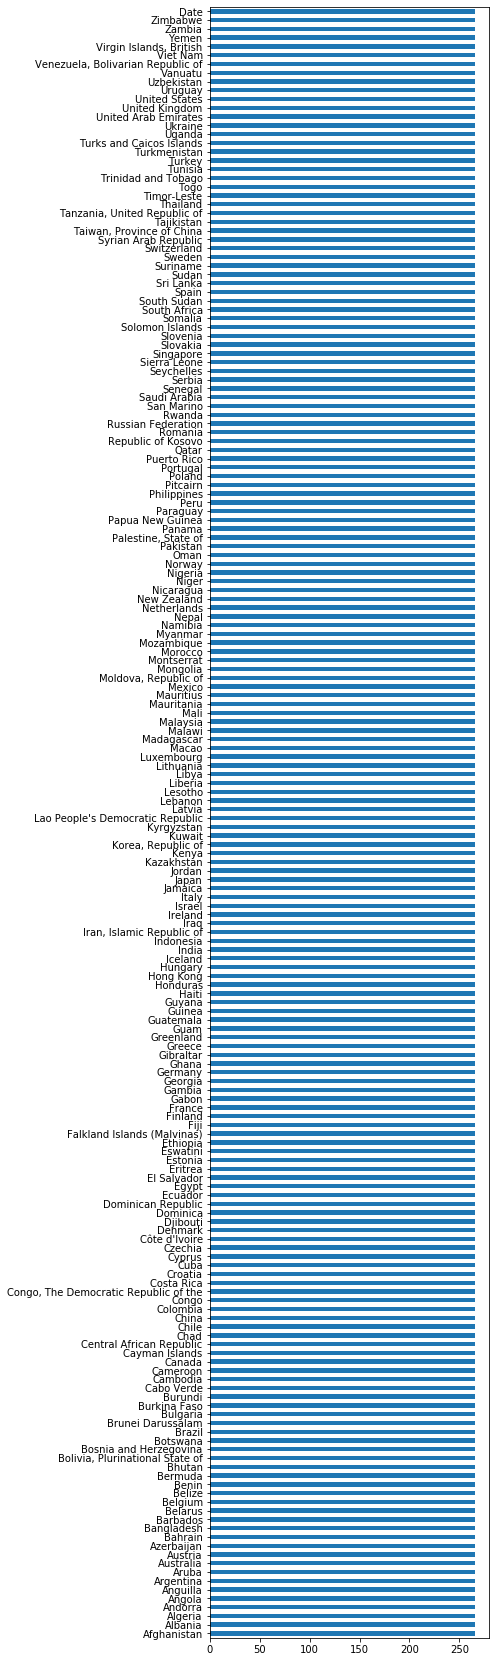

In [7]:
plt.figure(figsize=[5,30])
pd.Series({x:len(symbolised[x]) for x in symbolised}).plot.barh()

## Single country cases

Bag-of-words using 4 symbols



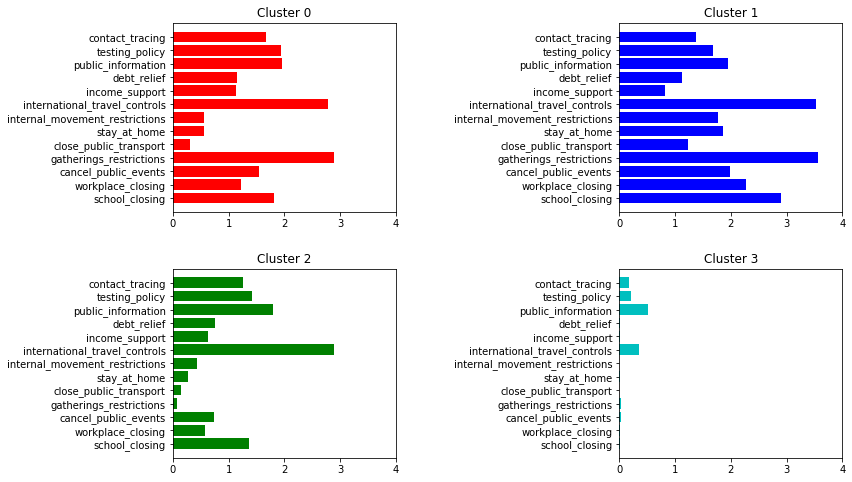

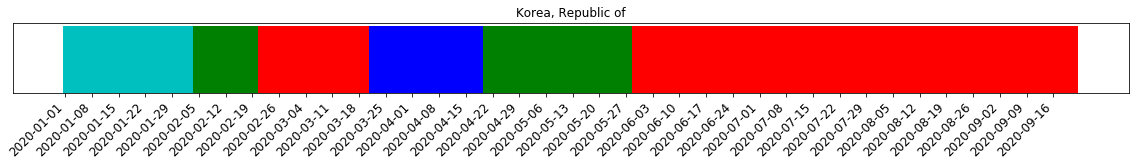

In [102]:
country = 'Korea, Republic of'
num_symbols = 4

# perform clustering
print('Bag-of-words using %d symbols' % num_symbols)
cols = 2
km = KMeans(n_clusters=num_symbols, random_state=0).fit(df_si[var_scales].dropna().to_numpy())
#centers = np.round(km.cluster_centers_)
centers = km.cluster_centers_
rows = np.ceil(centers.shape[0] / cols)
plt.figure(figsize=[12, 4*rows])
for i in range(centers.shape[0]):
    plt.subplot(rows, 2, i+1)
    plt.barh(y=list(var_scales.keys()), height=0.8, width=centers[i], color=symbol_colors[i])
    plt.subplots_adjust(wspace=1, hspace=0.3)
    plt.title('Cluster %d' % i)
    plt.xlim([0, 4])
    
# visualise bag of words
plt.figure(figsize=[20, 1])
df_country = df_si[df_si['country_name'] == country].set_index('Date', drop=True)[var_scales].dropna()
labels = km.predict(df_country)
for s in range(num_symbols):
    plt.bar(x=np.where(labels==s)[0], height=1, color=symbol_colors[s], width=1)
plt.title(country)
plt.xticks(list(range(len(df_country.index)))[::7], df_country.index[::7])
plt.yticks([])
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.1)
plt.xticks(fontsize=12, ha='right', rotation=45)
print()

Bag-of-words using 5 symbols



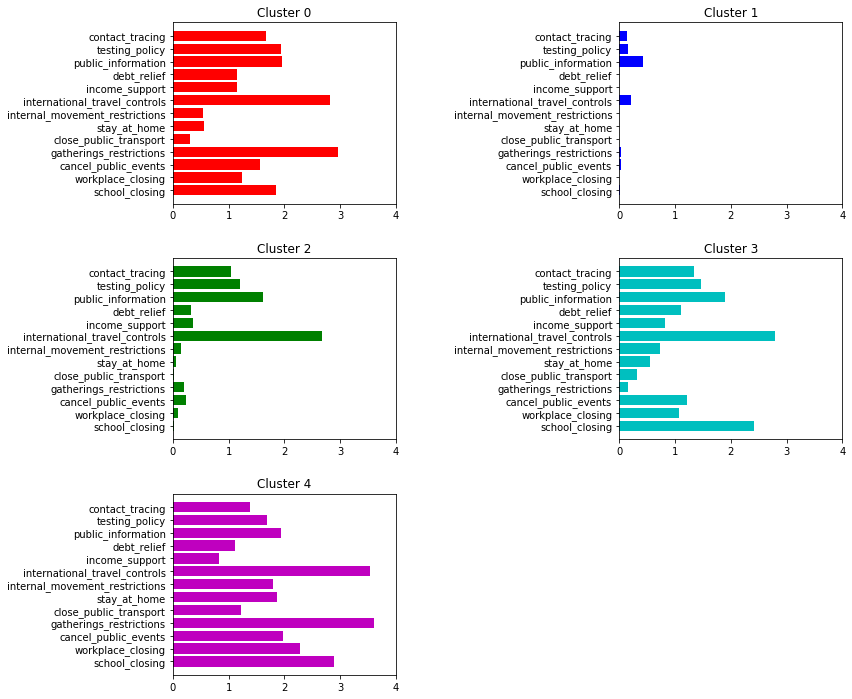

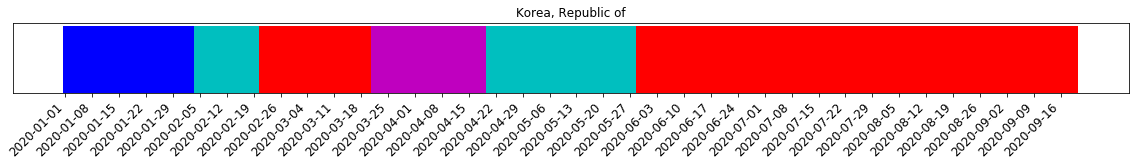

In [313]:
country = 'Korea, Republic of'
num_symbols = 5

# perform clustering
print('Bag-of-words using %d symbols' % num_symbols)
cols = 2
km = KMeans(n_clusters=num_symbols, random_state=0).fit(df_si[var_scales].dropna().to_numpy())
#centers = np.round(km.cluster_centers_)
centers = km.cluster_centers_
rows = np.ceil(centers.shape[0] / cols)
plt.figure(figsize=[12, 4*rows])
for i in range(centers.shape[0]):
    plt.subplot(rows, 2, i+1)
    plt.barh(y=list(var_scales.keys()), height=0.8, width=centers[i], color=symbol_colors[i])
    plt.subplots_adjust(wspace=1, hspace=0.3)
    plt.title('Cluster %d' % i)
    plt.xlim([0, 4])

# visualise bag of words
plt.figure(figsize=[20, 1])
df_country = df_si[df_si['country_name'] == country].set_index('Date', drop=True)[var_scales].dropna()
labels = km.predict(df_country)
for s in range(num_symbols):
    plt.bar(x=np.where(labels==s)[0], height=1, color=symbol_colors[s], width=1)
plt.title(country)
plt.xticks(list(range(len(df_country.index)))[::7], df_country.index[::7])
plt.yticks([])
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.1)
plt.xticks(fontsize=12, ha='right', rotation=45)
print()

Bag-of-words using 4 symbols



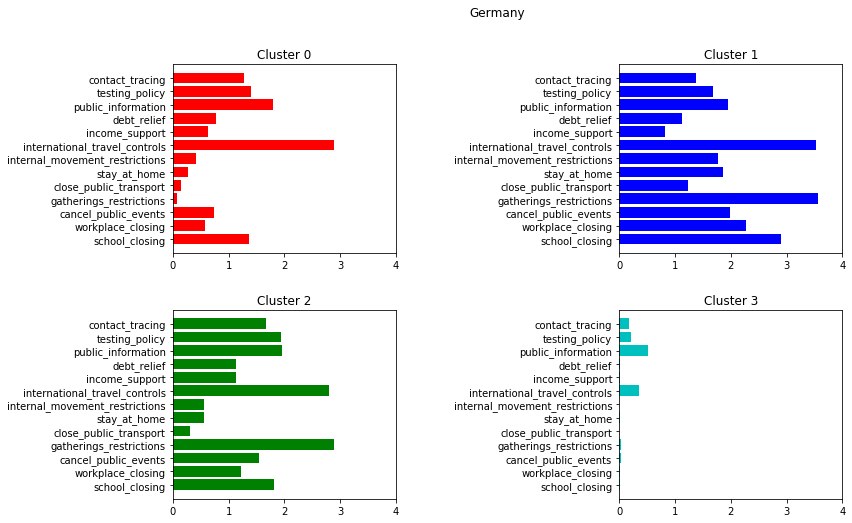

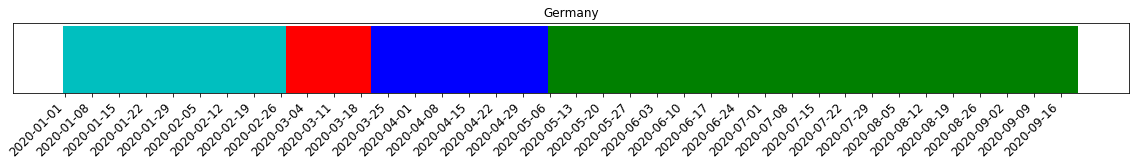

In [207]:
country = 'Germany'
num_symbols = 4

# perform clustering
print('Bag-of-words using %d symbols' % num_symbols)
cols = 2
km = KMeans(n_clusters=num_symbols, random_state=0).fit(df_si[var_scales].dropna().to_numpy())
#centers = np.round(km.cluster_centers_)
centers = km.cluster_centers_
rows = np.ceil(centers.shape[0] / cols)
plt.figure(figsize=[12, 4*rows])
for i in range(centers.shape[0]):
    plt.subplot(rows, 2, i+1)
    plt.barh(y=list(var_scales.keys()), height=0.8, width=centers[i], color=symbol_colors[i])
    plt.subplots_adjust(wspace=1, hspace=0.3)
    plt.title('Cluster %d' % i)
    plt.xlim([0, 4])
plt.suptitle(country)

# visualise bag of words
plt.figure(figsize=[20, 1])
df_country = df_si[df_si['country_name'] == country].set_index('Date', drop=True)[var_scales].dropna()
labels = km.predict(df_country)
for s in range(num_symbols):
    plt.bar(x=np.where(labels==s)[0], height=1, color=symbol_colors[s], width=1)
plt.title(country)
plt.xticks(list(range(len(df_country.index)))[::7], df_country.index[::7])
plt.yticks([])
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.1)
plt.xticks(fontsize=12, ha='right', rotation=45)
print()


Bag-of-words using 4 symbols



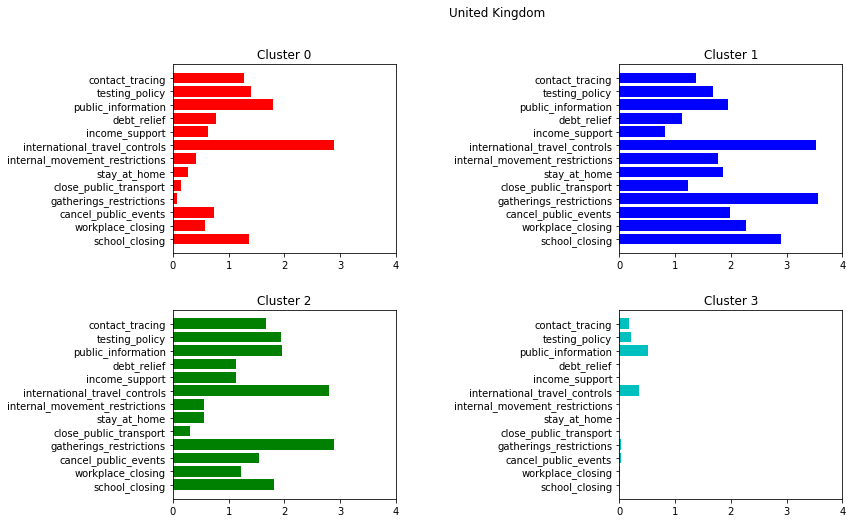

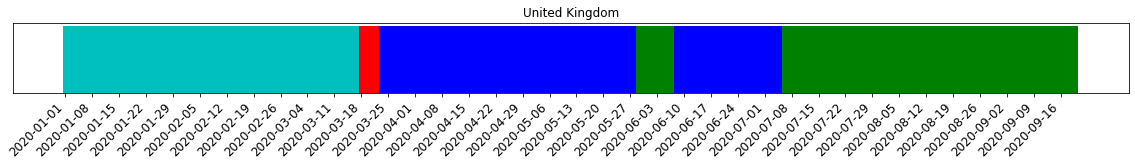

In [205]:
country = 'United Kingdom'
num_symbols = 4

# perform clustering
print('Bag-of-words using %d symbols' % num_symbols)
cols = 2
km = KMeans(n_clusters=num_symbols, random_state=0).fit(df_si[var_scales].dropna().to_numpy())
#centers = np.round(km.cluster_centers_)
centers = km.cluster_centers_
rows = np.ceil(centers.shape[0] / cols)
plt.figure(figsize=[12, 4*rows])
for i in range(centers.shape[0]):
    plt.subplot(rows, 2, i+1)
    plt.barh(y=list(var_scales.keys()), height=0.8, width=centers[i], color=symbol_colors[i])
    plt.subplots_adjust(wspace=1, hspace=0.3)
    plt.title('Cluster %d' % i)
    plt.xlim([0, 4])
plt.suptitle(country)

# visualise bag of words
plt.figure(figsize=[20, 1])
df_country = df_si[df_si['country_name'] == country].set_index('Date', drop=True)[var_scales].dropna()
labels = km.predict(df_country)
for s in range(num_symbols):
    plt.bar(x=np.where(labels==s)[0], height=1, color=symbol_colors[s], width=1)
plt.title(country)
plt.xticks(list(range(len(df_country.index)))[::7], df_country.index[::7])
plt.yticks([])
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.1)
plt.xticks(fontsize=12, ha='right', rotation=45)
print()


# Clustering using n-grams with bag of words

### Histrogram representation with n-grams based on bag of words

In [10]:
# compute n-grams table
def ngrams(n, strings, num_symbols):
    result = [0] * (num_symbols**2)
    symbol_list = []
    symbol_index = {}
    index = 0
    for s1 in string.ascii_uppercase[:num_symbols]:
        for s2 in string.ascii_uppercase[:num_symbols]:
            symbol = s1 + s2
            symbol_list.append(symbol)
            symbol_index[symbol] = index
            index += 1
    for i in range(0, (len(strings)-n)):
        sub = strings[i:i+n]
        result[symbol_index[sub]] += 1
    return symbol_list, np.array(result)

In [11]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

-- Cluster symbol definition --
Cluster 0 -> A
Cluster 1 -> B
Cluster 2 -> C
Cluster 3 -> D



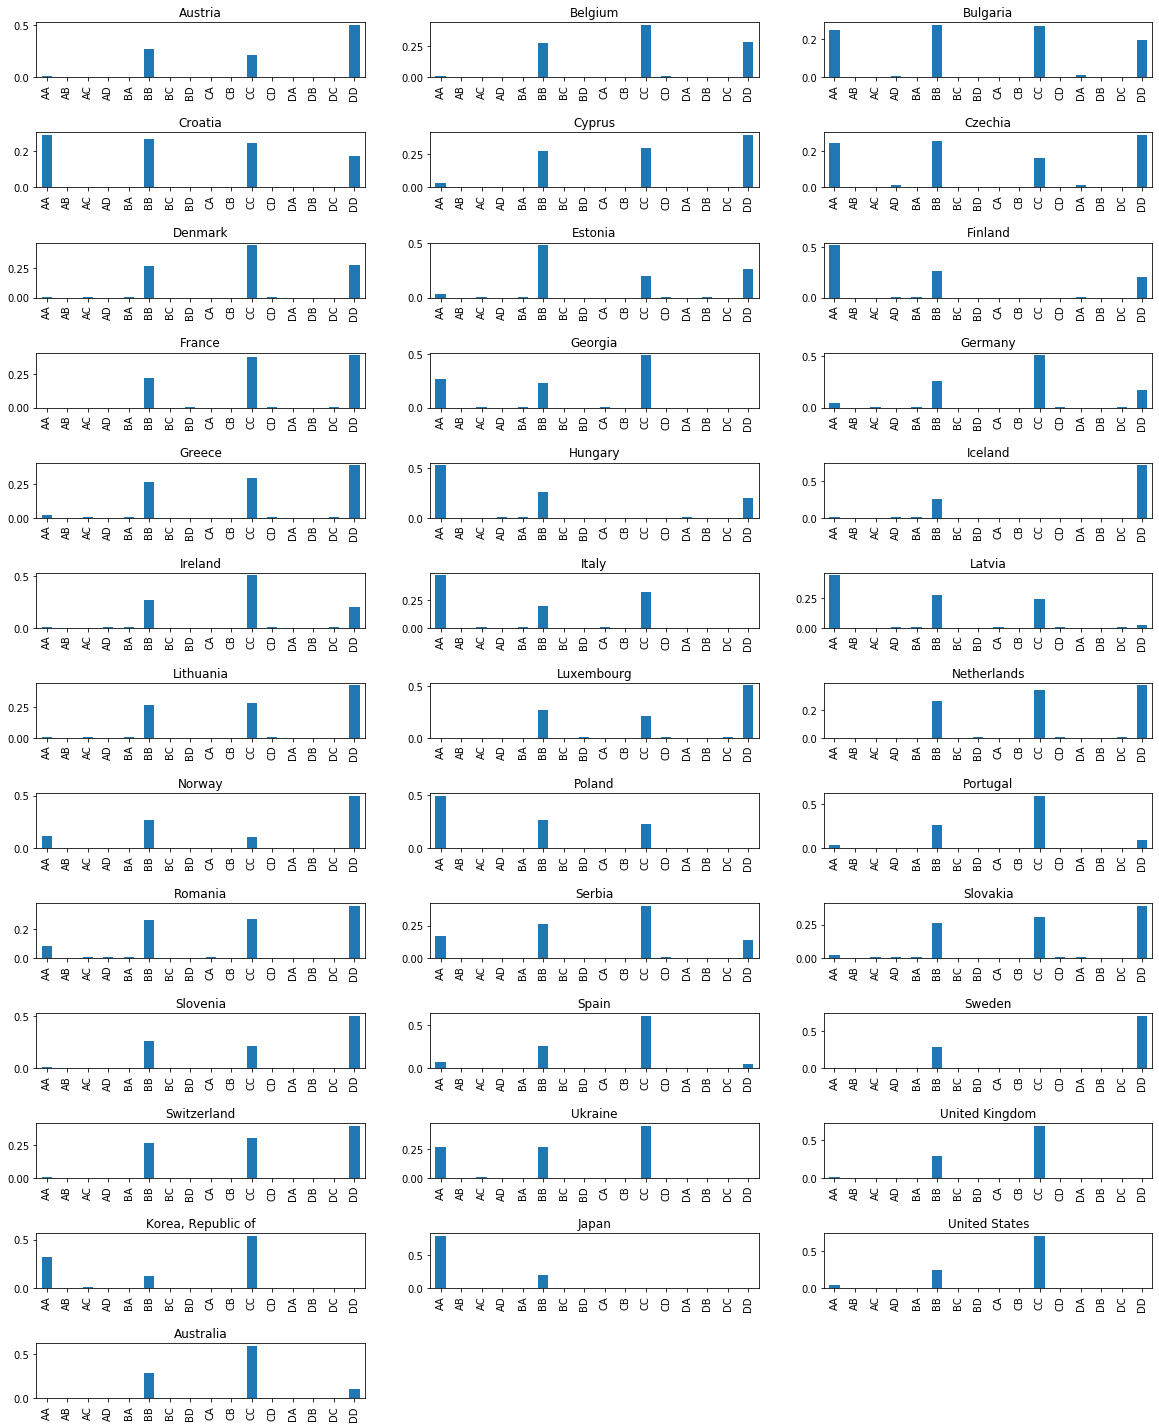

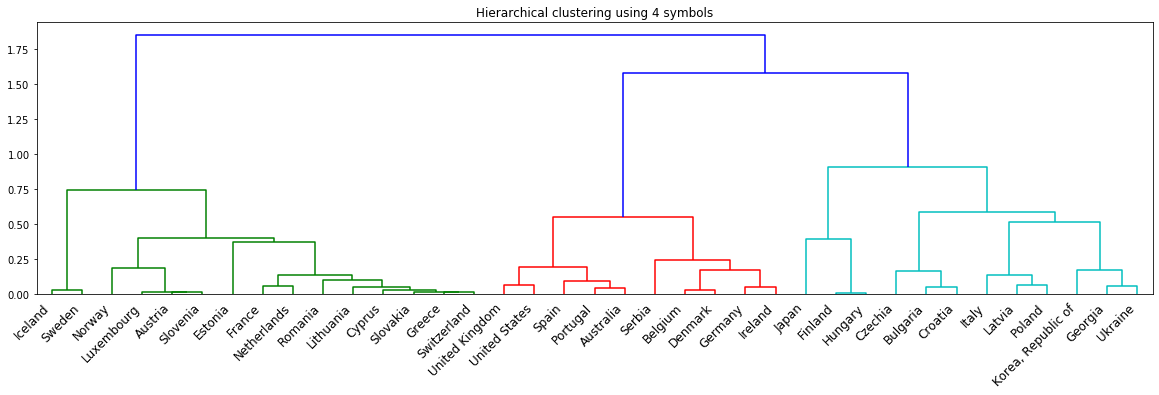

In [307]:
#countries_of_interest = ['Korea, Republic of', 'Germany', 'Austria', 'United Kingdom', 'Sweden', 'Iceland', 'Italy', 'France', 'Spain', 'Japan', 'China', 'United States', 'Australia', 'Iran, Islamic Republic of', 'Brazil']
countries_of_interest = europe + ['Korea, Republic of', 'Japan', 'United States', 'Australia']
num_symbols = 4
cols = 3
rows = np.ceil(len(countries_of_interest) / cols)
si_vectors = []

print('-- Cluster symbol definition --')
for i in range(num_symbols):
    print('Cluster %d -> %s' % (i, string.ascii_uppercase[i]))
plt.figure(figsize=[20, 1.5*rows])

km = KMeans(n_clusters=num_symbols, random_state=0).fit(df_si[df_si.country_name.isin(countries_of_interest)][var_scales].dropna().to_numpy())
for i, country in enumerate(countries_of_interest):
    plt.subplot(rows, cols, i+1)
    df_country = df_si[df_si['country_name'] == country].set_index('Date', drop=True)[var_scales].dropna()
    if df_country.shape[0] < 10:
        continue
    labels = km.predict(df_country)
    states = ''.join([string.ascii_uppercase[x] for x in labels])
    #print(states)
    symlist, ngtable = ngrams(2, states, num_symbols)
    ngtable_norm = ngtable / sum(ngtable)
    si_vectors.append(ngtable_norm)
    pd.Series(ngtable_norm, symlist).plot.bar()
    plt.title(country)
    plt.subplots_adjust(top=0.99, bottom=0.01, hspace=1, wspace=0.2)
    
plt.figure(figsize=[20,5])
ac = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ac.fit(si_vectors, countries_of_interest)
plt.title('Hierarchical clustering using %d symbols' % num_symbols)
# plot the top three levels of the dendrogram
plot_dendrogram(ac, truncate_mode='level', p=10, labels=countries_of_interest)
plt.xticks(fontsize=12, ha='right', rotation=45)
print()

### Batch trial with variable number of symbols

-- Cluster symbol definition --
Cluster 0 -> A
Cluster 1 -> B
Cluster 2 -> C
Cluster 3 -> D

-- Cluster symbol definition --
Cluster 0 -> A
Cluster 1 -> B
Cluster 2 -> C
Cluster 3 -> D
Cluster 4 -> E
Cluster 5 -> F
Cluster 6 -> G



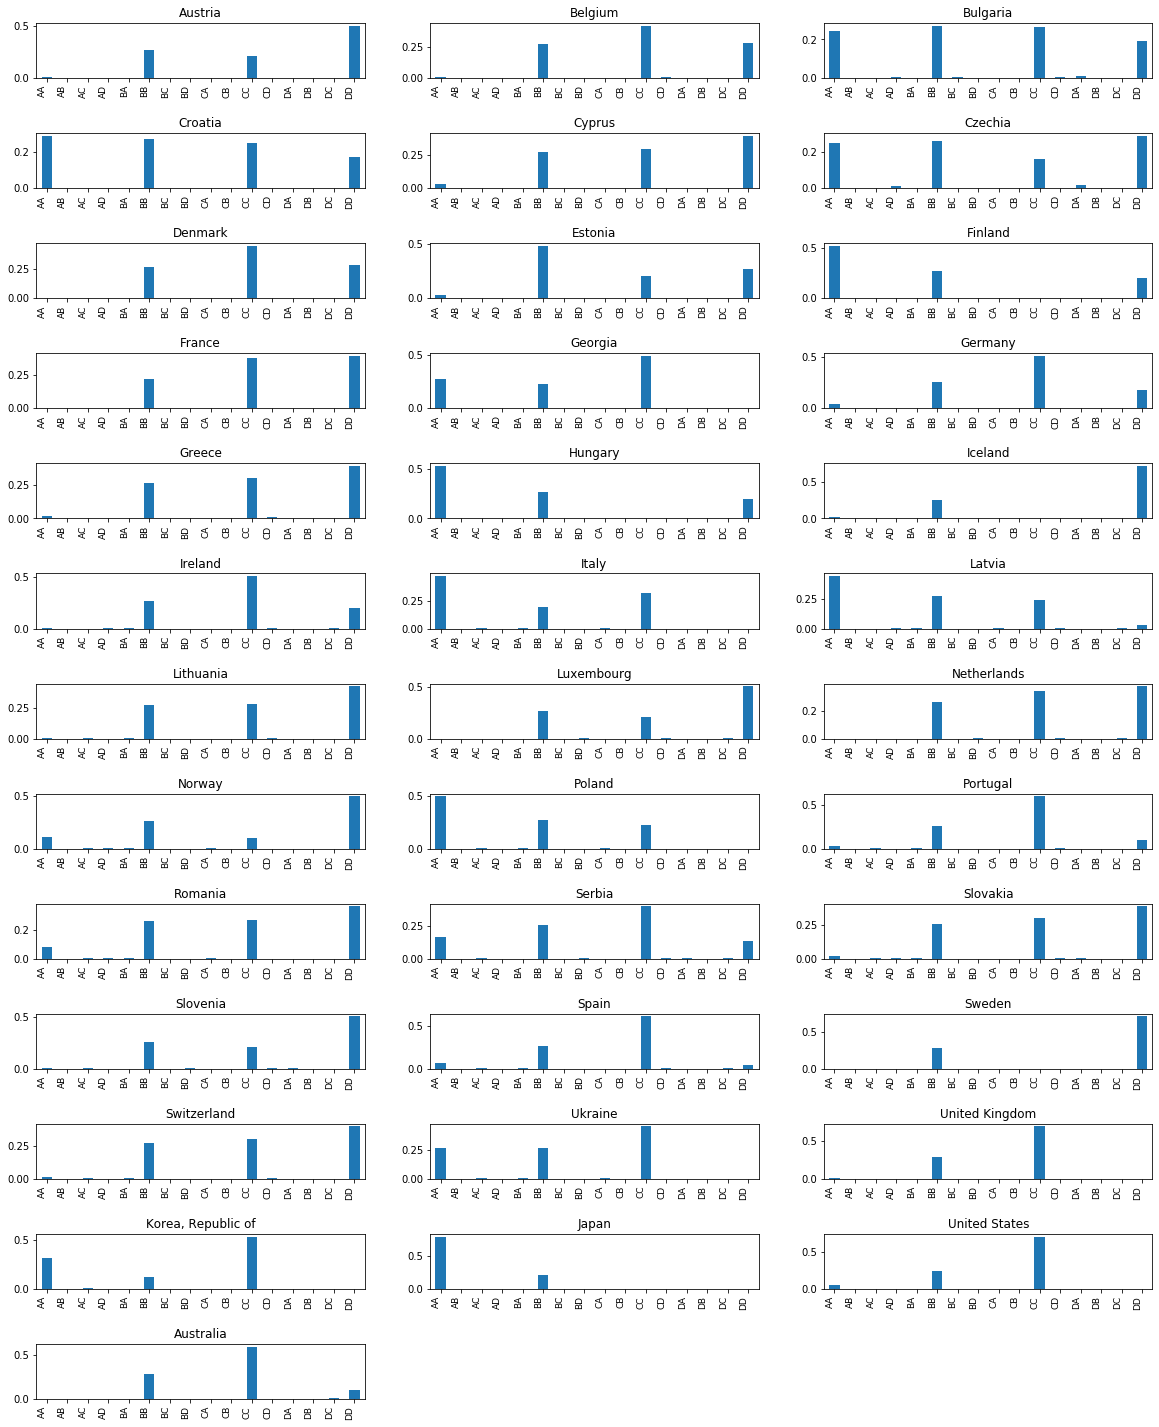

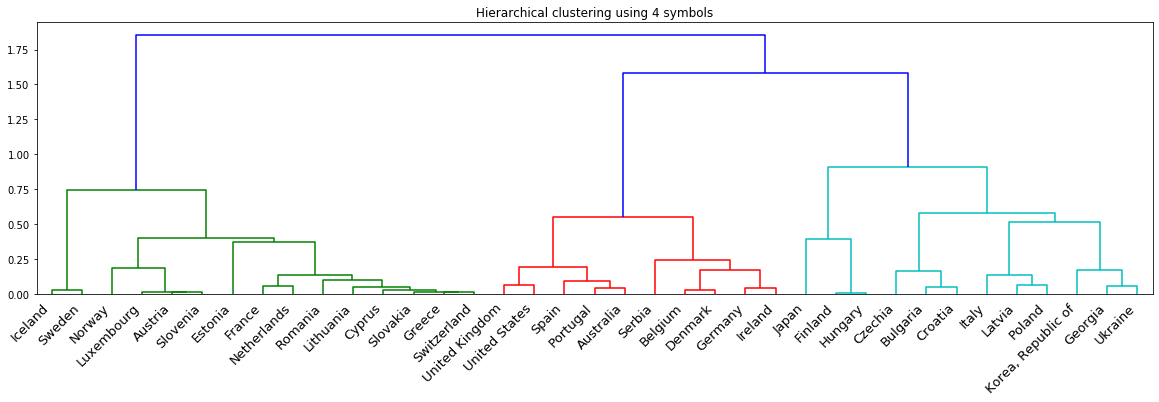

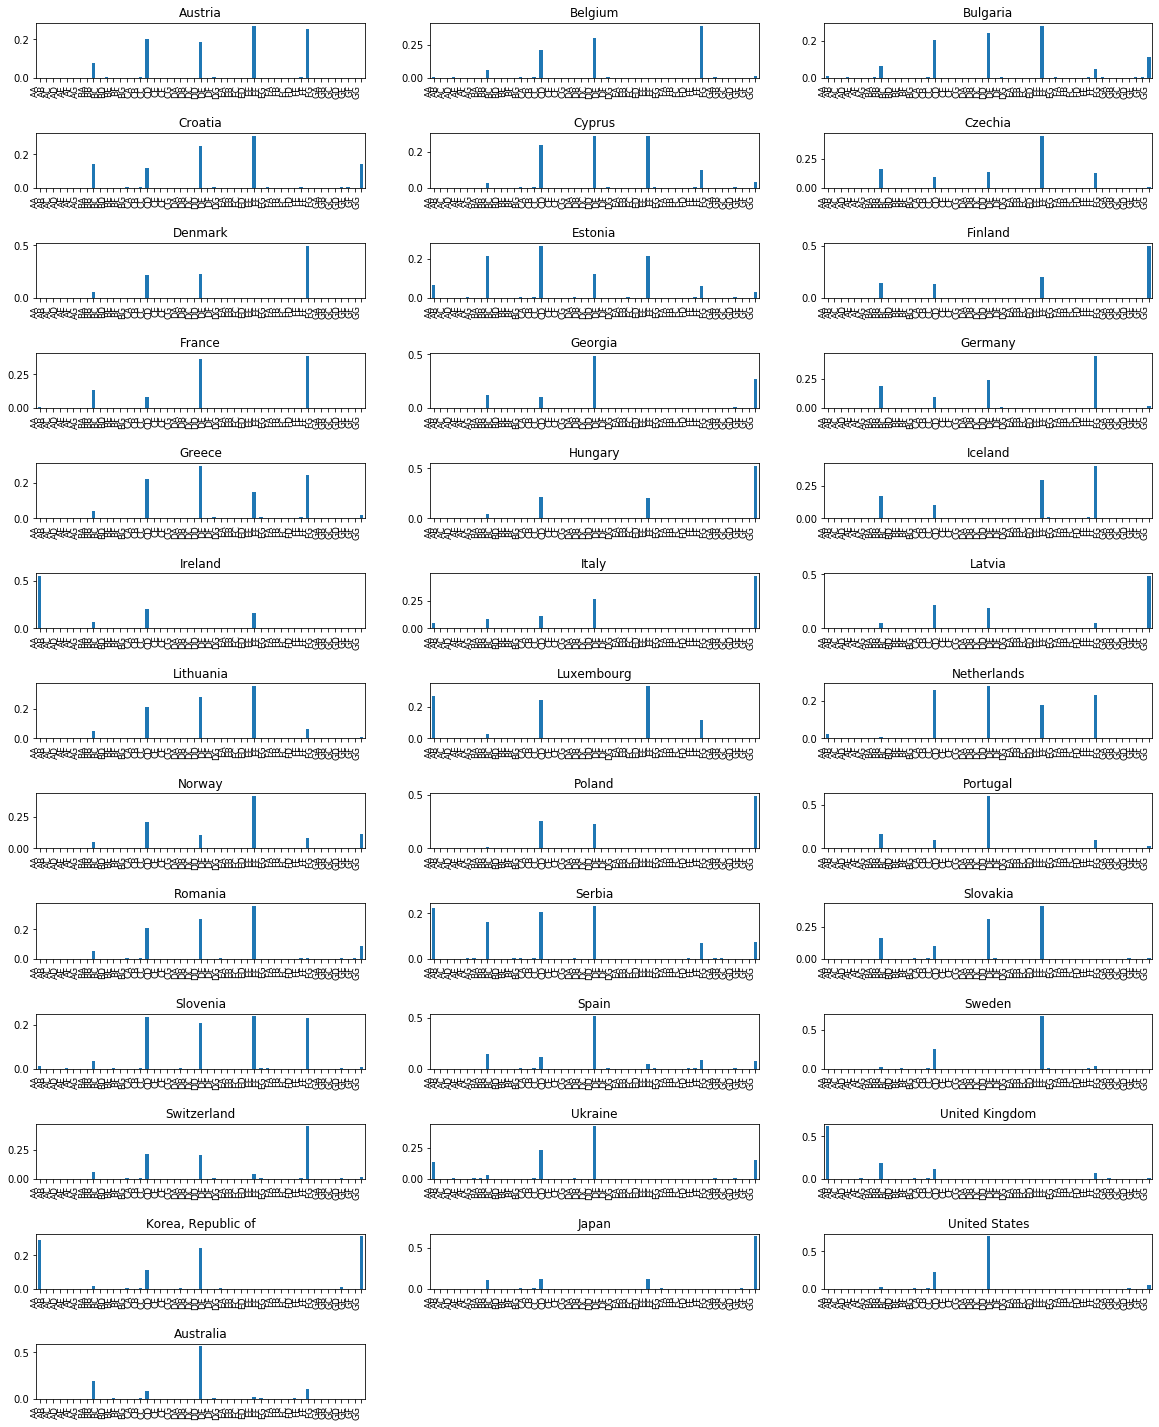

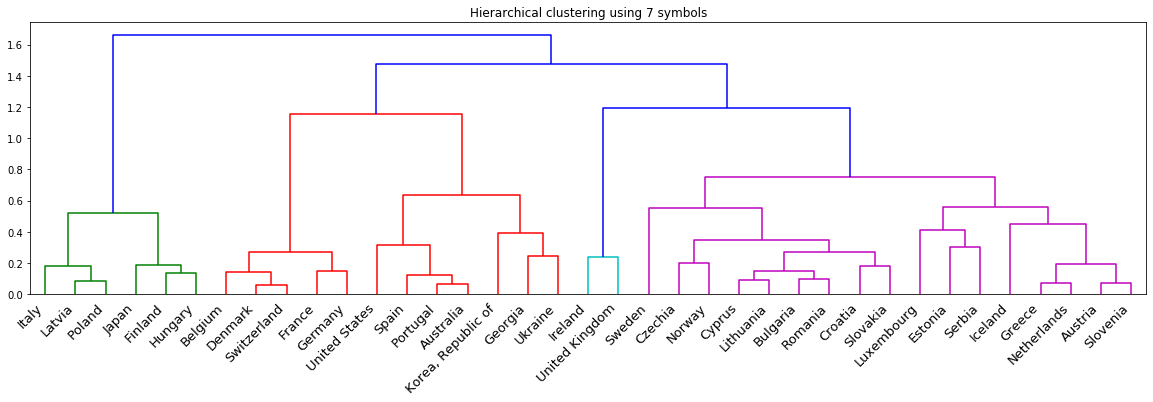

In [316]:
#countries_of_interest = ['Korea, Republic of', 'Germany', 'Austria', 'United Kingdom', 'Sweden', 'Iceland', 'Italy', 'France', 'Spain', 'Japan', 'China', 'United States', 'Australia', 'Iran, Islamic Republic of', 'Brazil']
countries_of_interest = europe + ['Korea, Republic of', 'Japan', 'United States', 'Australia']
num_symbol_options = [4, 7]
cols = 3
rows = np.ceil(len(countries_of_interest) / cols)

for num_symbols in num_symbol_options:
    print('-- Cluster symbol definition --')
    for i in range(num_symbols):
        print('Cluster %d -> %s' % (i, string.ascii_uppercase[i]))
    plt.figure(figsize=[20, 1.5*rows])

    si_vectors = []
    km = KMeans(n_clusters=num_symbols, random_state=0).fit(df_si[df_si.country_name.isin(countries_of_interest)][var_scales].dropna().to_numpy())
    for i, country in enumerate(countries_of_interest):
        plt.subplot(rows, cols, i+1)
        df_country = df_si[df_si['country_name'] == country].set_index('Date', drop=True)[var_scales].dropna()
        if df_country.shape[0] < 10:
            continue
        labels = km.predict(df_country)
        states = ''.join([string.ascii_uppercase[x] for x in labels])
        #print(states)
        symlist, ngtable = ngrams(2, states, num_symbols)
        ngtable_norm = ngtable / sum(ngtable)
        si_vectors.append(ngtable_norm)
        pd.Series(ngtable_norm, symlist).plot.bar()
        plt.xticks(fontsize=9, ha='right', rotation=90)
        plt.title(country)
        plt.subplots_adjust(top=0.99, bottom=0.01, hspace=1, wspace=0.2)

    plt.figure(figsize=[20,5])
    ac = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    ac.fit(si_vectors, countries_of_interest)
    plt.title('Hierarchical clustering using %d symbols' % num_symbols)
    # plot the top three levels of the dendrogram
    plot_dendrogram(ac, truncate_mode='level', p=10, labels=countries_of_interest)
    plt.xticks(fontsize=13, ha='right', rotation=45)
    print()

# State transition model

### State transition probabilities for all countries

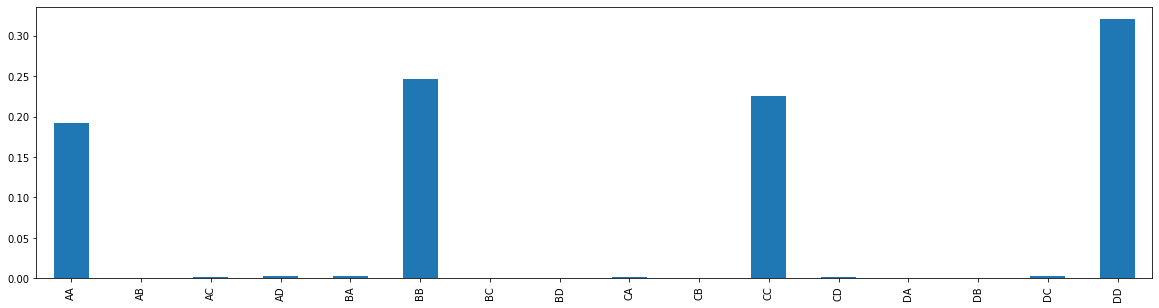

In [109]:
countries_of_interest = europe + ['Korea, Republic of', 'Japan', 'United States', 'Australia']
num_symbols = 4

si_vectors = [0] * (num_symbols**2)
km = KMeans(n_clusters=num_symbols, random_state=0).fit(df_si[df_si.country_name.isin(countries_of_interest)][var_scales].dropna().to_numpy())
for i, country in enumerate(countries_of_interest):
    df_country = df_si[df_si['country_name'] == country].set_index('Date', drop=True)[var_scales].dropna()
    if df_country.shape[0] < 10:
        continue
    labels = km.predict(df_country)
    states = ''.join([string.ascii_uppercase[x] for x in labels])
    symlist, ngtable = ngrams(2, states, num_symbols)
    si_vectors = si_vectors + ngtable / sum(ngtable)

si_vectors = si_vectors / sum(si_vectors)
si_transitions = si_vectors.reshape([num_symbols, num_symbols])
si_transitions = np.round(si_transitions, decimals=3)

plt.figure(figsize=[20, 5])
pd.Series(si_vectors, index=symlist).plot.bar()

chain = Chain(num_symbols, 0)
g = Digraph(format='svg', engine='dot',
            graph_attr={'pad':'0.1', 'nodesep':'0.4', 'ranksep':'0.1'},
            node_attr={'fontname':'Helvetica'},
            edge_attr={'fontsize':'8.0', 'fontname':'Helvetica'}
)
transitions_to_graph(g, si_transitions, lambda s:string.ascii_uppercase[s])
g.view()

print()


### State transition probabilities for each country

In [ ]:
from markovchain import MarkovChain

countries_of_interest = europe + ['Korea, Republic of', 'Japan', 'United States', 'Australia']
num_symbols = 4

chain = Chain(num_symbols, string.ascii_uppercase[:num_symbols])  # create an empty Markov chain with 2 states
g = Digraph(format='svg', engine='dot',
            graph_attr={'pad': '0.1', 'nodesep': '0.4', 'ranksep': '1.0'},
            node_attr={'fontname': 'Helvetica'},
            edge_attr={'fontsize': '8.0', 'fontname': 'Helvetica'})

si_vectors = [0] * (num_symbols**2)
km = KMeans(n_clusters=num_symbols, random_state=0).fit(df_si[df_si.country_name.isin(countries_of_interest)][var_scales].dropna().to_numpy())
for i, country in enumerate(countries_of_interest):
    df_country = df_si[df_si['country_name'] == country].set_index('Date', drop=True)[var_scales].dropna()
    if df_country.shape[0] < 10:
        continue
    labels = km.predict(df_country)
    states = ''.join([string.ascii_uppercase[x] for x in labels])
    symlist, ngtable = ngrams(2, states, num_symbols)
    si_vectors = ngtable / sum(ngtable)
    si_transitions = si_vectors.reshape([num_symbols, num_symbols])
    si_transitions = np.round(si_transitions, decimals=3)

    plt.figure(figsize=[20,5])
    #pd.Series(si_vectors, index=symlist).plot.bar()
    mc = MarkovChain(si_transitions, string.ascii_uppercase[:num_symbols])
    mc.draw()
    plt.title(country)

transitions_to_graph(g, si_transitions, lambda s: string.ascii_uppercase[s])
g.view()
print()
